In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
original_images_folder_path = './images/original'  # 原始图片文件夹路径
output_image_folder_path = './images/output'  # 输出图片文件夹路径

In [3]:
# 从原始图片文件夹加载图片（原始文件夹仅限两张图片且图片名按拍摄角度从左到右编号）
def load_images(folder_path):
        images = os.listdir(folder_path)
        images_list = []
        for img in images:
            img_read = cv2.imread(folder_path + os.sep + img)
            images_list.append(img_read)
        return images_list

In [4]:
class ImageStitching:
    def __init__(self, ratio=0.65, min_match=5, smoothing_window_size=100):
        self.ratio = ratio  # 特征点匹配的阈值
        self.min_match = min_match  # 最小匹配点数量
        self.smoothing_window_size = smoothing_window_size  # 融合部分的平滑窗大小
        self.sift = cv2.SIFT_create()  # 创建SIFT算子

    # 计算两张图片之间的单应性矩阵
    def registration(self, img1, img2, output_path):
        # 使用SIFT获得特征点
        key_point1, des1 = self.sift.detectAndCompute(img1, None)
        key_point2, des2 = self.sift.detectAndCompute(img2, None)
        raw_matches = cv2.BFMatcher().knnMatch(des1, des2, k=2)  # 使用Brute-Force匹配器，对两幅图像中的特征点进行匹配
        best_features = []
        best_matches = []

        # 通过KNN（K=2）获得最佳特征点
        for m1, m2 in raw_matches:
            if m1.distance < self.ratio * m2.distance:
                best_features.append((m1.trainIdx, m1.queryIdx))
                best_matches.append([m1])
        img3 = cv2.drawMatchesKnn(img1, key_point1, img2, key_point2, best_matches, None, flags=2)

        cv2.imwrite(output_path + os.sep + 'matching.jpg', img3)  # 输出特征点匹配图

        # 如果匹配的特征点数量超过了指定的最小匹配数，该方法将返回单应性矩阵
        if len(best_features) > self.min_match:
            image1_kp = np.float32(
                [key_point1[i].pt for (_, i) in best_features])
            image2_kp = np.float32(
                [key_point2[i].pt for (i, _) in best_features])
            # 计算单应性矩阵，加入了Ransac
            h, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC, 5.0)
            return h
        else:
            print(f'两张图的特征点小于{self.min_match}，请检查两张图是否有关联。')
            exit(1)

    # 创建融合图像时的掩膜（mask）
    def create_mask(self, img1, img2, side):
        height_blended = img1.shape[0]
        width_blended = img1.shape[1] + img2.shape[1]
        offset = int(self.smoothing_window_size / 2)
        barrier = img1.shape[1] - int(self.smoothing_window_size / 2)
        mask = np.zeros((height_blended, width_blended))

        # 左右图使用不同的masK
        if side == 'left':
            mask[:, barrier - offset:barrier + offset] = np.tile(np.linspace(1, 0, 2 * offset).T, (height_blended, 1))
            mask[:, :barrier - offset] = 1
        else:
            mask[:, barrier - offset:barrier + offset] = np.tile(np.linspace(0, 1, 2 * offset).T, (height_blended, 1))
            mask[:, barrier + offset:] = 1
        return cv2.merge([mask, mask, mask])

    # 图像融合拼接
    def blending(self, img1, img2, output_path):
        # 获得单应性矩阵
        h = self.registration(img1, img2, output_path)
        height_blended = img1.shape[0]
        width_blended = img1.shape[1] + img2.shape[1]

        # 进行图片仿射变换与融合
        blend1 = np.zeros((height_blended, width_blended, 3))
        blend1[0:img1.shape[0], 0:img1.shape[1], :] = img1
        blend1 *= self.create_mask(img1, img2, 'left')
        blend2 = cv2.warpPerspective(img2, h, (width_blended, height_blended)) * self.create_mask(img1, img2, 'right')
        result = blend1 + blend2

        rows, cols = np.where(result[:, :, 0] != 0)
        result_image = result[min(rows):max(rows) + 1, min(cols):max(cols) + 1, :]
        return result_image

    # 拼接结果展示
    def stitching(self, images, output_path):
        img_stitched = self.blending(images[0], images[1], output_path)
        cv2.imwrite(output_path + os.sep + 'output.jpg', img_stitched)
        plt.imshow(img_stitched[:,:,::-1].astype('uint8'))

In [5]:
imgs = load_images(original_images_folder_path)
img_1, img_2 = imgs

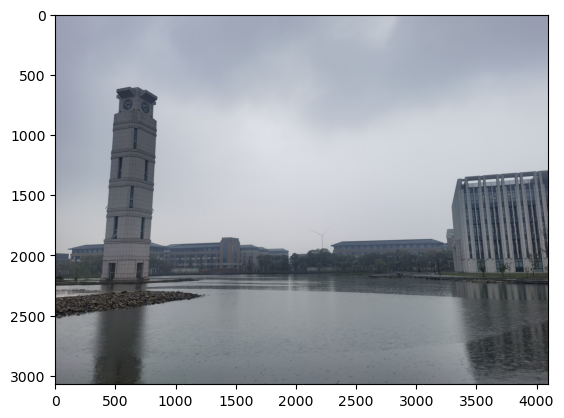

In [6]:
plt.imshow(img_1[:,:,::-1])

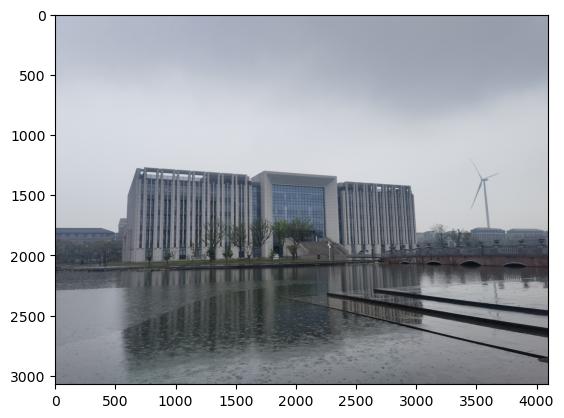

In [7]:
plt.imshow(img_2[:,:,::-1])

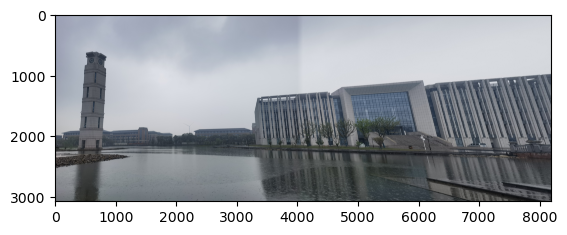

In [8]:
stitch = ImageStitching()
stitch.stitching(imgs, output_image_folder_path)